In [1]:
import pandas as pd
import os
import numpy as np
import pydicom
import cv2
import torch
import gc
import pickle
import random
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from ensemble_boxes import weighted_boxes_fusion
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [2]:
def load_dict(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [3]:
studyids = []
for x in Path('../../dataset/siim-covid19-detection/test').iterdir():
    if x.is_dir():
        studyids.append(x.name)
studyids = random.sample(studyids, 6)
print(studyids)

['80e1c35abd04', 'bc76c0035143', '8066c8d7cba7', 'd8cf28d0aa53', '0dd6457640a2', '9852d2660b69']


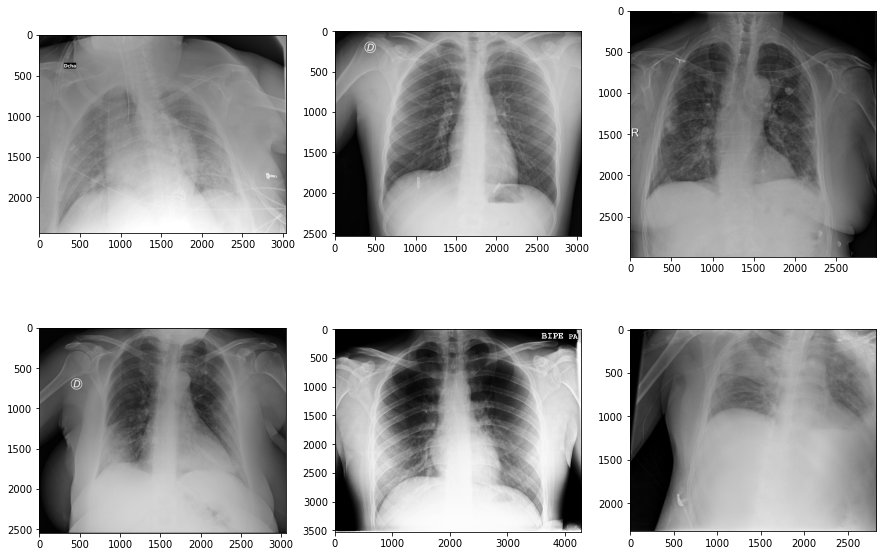

In [4]:
### extract dicom to image
os.makedirs('./images', exist_ok=True)
os.makedirs('./csv', exist_ok=True)

meta_data = []
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, studyid in enumerate(studyids):
    for rdir, _, files in os.walk('../../dataset/siim-covid19-detection/test/{}'.format(studyid)):
        for file in files:
            file_path = os.path.join(rdir, file)
            filename, file_extension = os.path.splitext(file_path)
            if file_extension not in ['.dcm', '.dicom']:
                continue
            dcm_file = pydicom.read_file(file_path)
            patient_id = dcm_file.PatientID
            series_id = dcm_file.SeriesInstanceUID
            image_id = dcm_file.SOPInstanceUID
            assert studyid == dcm_file.StudyInstanceUID

            data = apply_voi_lut(dcm_file.pixel_array, dcm_file)
            
            if dcm_file.PhotometricInterpretation == "MONOCHROME1":
                data = np.amax(data) - data

            data = data - np.min(data)
            data = data / np.max(data)
            data = (data * 255).astype(np.uint8)
            
            image_path = './images/{}.png'.format(image_id)
            cv2.imwrite(image_path, data)
            
            ax[idx//3, idx%3].imshow(data, cmap='gray')
            
            meta_data.append([patient_id, studyid, series_id, image_id, dcm_file.SeriesNumber, dcm_file.InstanceNumber])
plt.show()
test_df = pd.DataFrame(data=np.array(meta_data), columns=['patientid', 'studyid', 'series_id', 'imageid', 'SeriesNumber', 'InstanceNumber'])
test_df.to_csv('./csv/test_df.csv', index=False)

In [5]:
################################ crop lung area ################################
### yolov5
!cp -r ../detection_lung_yolov5/data .
!cp -r ../detection_lung_yolov5/models .
!cp -r ../detection_lung_yolov5/utils .
!cp -r ../detection_lung_yolov5/*.py .
!python demo_predict.py --ckpt_dir ../detection_lung_yolov5/runs/train \
                        --output_dir ./predictions \
                        --output_file_name yolov5_lung_test_pred.pth \
                        --fold 3 --source ./images --img-size 512 --conf-thres 0.05 --iou-thres 0.5 --device 0
!rm -rf ./utils ./models ./data *.py ./__pycache__
### visualize lung prediction
test_pred = torch.load('./predictions/yolov5_lung_test_pred.pth')
test_df = pd.read_csv('./csv/test_df.csv')
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, row in test_df.iterrows():
    image_path = './images/{}.png'.format(row['imageid'])
    image = cv2.imread(image_path)
    ori_height, ori_width = image.shape[0:2]
    image = cv2.resize(image, (2048, 2048)) 
    
    lung_x1, lung_y1, lung_x2, lung_y2 = test_pred[row['imageid']]
    lung_x1 = int(lung_x1*2048/ori_width)
    lung_x2 = int(lung_x2*2048/ori_width)
    lung_y1 = int(lung_y1*2048/ori_height)
    lung_y2 = int(lung_y2*2048/ori_height)
    
    cv2.rectangle(image, (lung_x1, lung_y1), (lung_x2, lung_y2), (255,0,0), 10)
    ax[idx//3, idx%3].imshow(image)
    ax[idx//3, idx%3].set_xlabel(row['imageid'], fontsize=12)
plt.show()

Traceback (most recent call last):
  File "demo_predict.py", line 47, in <module>
    model = attempt_load(CHECKPOINT, map_location=device)  # load FP32 model
  File "/mnt/750G/GIT/COVID19/src/demo_notebook/models/experimental.py", line 118, in attempt_load
    ckpt = torch.load(w, map_location=map_location)  # load
  File "/home/sergey/anaconda3/envs/covid19/lib/python3.7/site-packages/torch/serialization.py", line 581, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/home/sergey/anaconda3/envs/covid19/lib/python3.7/site-packages/torch/serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/home/sergey/anaconda3/envs/covid19/lib/python3.7/site-packages/torch/serialization.py", line 211, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: '../detection_lung_yolov5/runs/train/fold3/weights/best.pt'


FileNotFoundError: [Errno 2] No such file or directory: './predictions/yolov5_lung_test_pred.pth'

In [6]:
################################ study level prediction ################################
!cp -r ../classification_aux/configs .
!cp -r ../classification_aux/segmentation_models_pytorch .
!cp -r ../classification_aux/*.py .

!python demo_predict.py --test_df ./csv/test_df.csv \
                        --ckpt_dir ../classification_aux/checkpoints_v4 \
                        --image_dir ./images \
                        --lung_pred_path ./predictions/yolov5_lung_test_pred.pth \
                        --output_dir ./predictions \
                        --cfg ./configs/eb5_512_deeplabv3plus.yaml \
                        --folds 0 1 2 3 4 \
                        --num_tta 8 \
                        --batch-size 8 \
                        --workers 2
                        
!python demo_predict.py --test_df ./csv/test_df.csv \
                        --ckpt_dir ../classification_aux/checkpoints_v4 \
                        --image_dir ./images \
                        --lung_pred_path ./predictions/yolov5_lung_test_pred.pth \
                        --output_dir ./predictions \
                        --cfg ./configs/seresnet152d_512_unet.yaml \
                        --folds 0 1 2 3 4 \
                        --num_tta 8 \
                        --batch-size 8 \
                        --workers 2

!python demo_predict.py --test_df ./csv/test_df.csv \
                        --ckpt_dir ../classification_aux/checkpoints_v4 \
                        --image_dir ./images \
                        --lung_pred_path ./predictions/yolov5_lung_test_pred.pth \
                        --output_dir ./predictions \
                        --cfg ./configs/eb6_448_linknet.yaml \
                        --folds 0 1 2 3 4 \
                        --num_tta 8 \
                        --batch-size 8 \
                        --workers 2

!python demo_predict.py --test_df ./csv/test_df.csv \
                        --ckpt_dir ../classification_aux/checkpoints_v4 \
                        --image_dir ./images \
                        --lung_pred_path ./predictions/yolov5_lung_test_pred.pth \
                        --output_dir ./predictions \
                        --cfg ./configs/eb7_512_unetplusplus.yaml \
                        --folds 0 1 2 3 4 \
                        --num_tta 8 \
                        --batch-size 8 \
                        --workers 2

!rm -rf *.py ./segmentation_models_pytorch ./configs ./__pycache__

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]


In [7]:
################################ image level prediction ################################
### yolov5
print('yolov5')
!cp -r ../detection_yolov5/data .
!cp -r ../detection_yolov5/models .
!cp -r ../detection_yolov5/utils .
!cp -r ../detection_yolov5/*.py .
!python demo_predict.py --ckpt_dir ../detection_yolov5/runs/train \
                        --output_dir ./predictions \
                        --folds 0 1 2 3 4 \
                        --source ./images \
                        --img-size 768 \
                        --conf-thres 0.0005 \
                        --iou-thres 0.5 \
                        --device 0
!rm -rf ./utils ./models ./data *.py ./__pycache__

### faster rcnn
print('faster rcnn')
!cp -r ../detection_fasterrcnn/*.py .
!cp -r ../detection_fasterrcnn/configs .
!python demo_predict.py --test_df ./csv/test_df.csv \
                        --ckpt_dir ../detection_fasterrcnn/checkpoints \
                        --image_dir ./images \
                        --output_dir ./predictions \
                        --cfg ./configs/resnet200d.yaml \
                        --folds 0 1 2 3 4 \
                        --batch-size 8 \
                        --workers 2
!python demo_predict.py --test_df ./csv/test_df.csv \
                        --ckpt_dir ../detection_fasterrcnn/checkpoints \
                        --image_dir ./images \
                        --output_dir ./predictions \
                        --cfg ./configs/resnet101d.yaml \
                        --folds 0 1 2 3 4 \
                        --batch-size 8 \
                        --workers 2
!rm -rf *.py ./configs ./__pycache__

### efficient det
print('efficient det')
!cp -r ../detection_efffdet/effdet .
!cp -r ../detection_efffdet/*.py .

!python demo_predict.py --model tf_efficientdet_d7 \
                        --amp --use-ema --num-classes 1 --native-amp -b 8 \
                        --output_dir ./predictions \
                        --test_df ./csv/test_df.csv \
                        --ckpt_dir ../detection_efffdet/checkpoints \
                        --image_dir ./images \
                        --folds 0 1 2 3 4 \
                        --image-size 768
!rm -rf ./effdet *.py ./__pycache__

yolov5
100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.62it/s]
faster rcnn
100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]
efficient det
Loaded state_dict_ema from checkpoint '../detection_efffdet/checkpoints/tf_efficientdet_d7_768_fold0/model_best.pth.tar'
Loaded state_dict_ema from checkpoint '../detection_efffdet/checkpoints/tf_efficientdet_d7_768_fold1/model_best.pth.tar'
Loaded state_dict_ema from checkpoint '../detection_efffdet/checkpoints/tf_efficientdet_d7_768_fold2/model_best.pth.tar'
Loaded state_dict_ema from checkpoint '../detection_efffdet/checkpoints/tf_efficientdet_d7_768_fold3/model_best.pth.tar'
Loaded state_dict_ema from checkpoint '../detection_efffdet/checkpoints/tf_efficientdet_d7_768_fold4/model_best.pth.tar'
100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.36s/it]


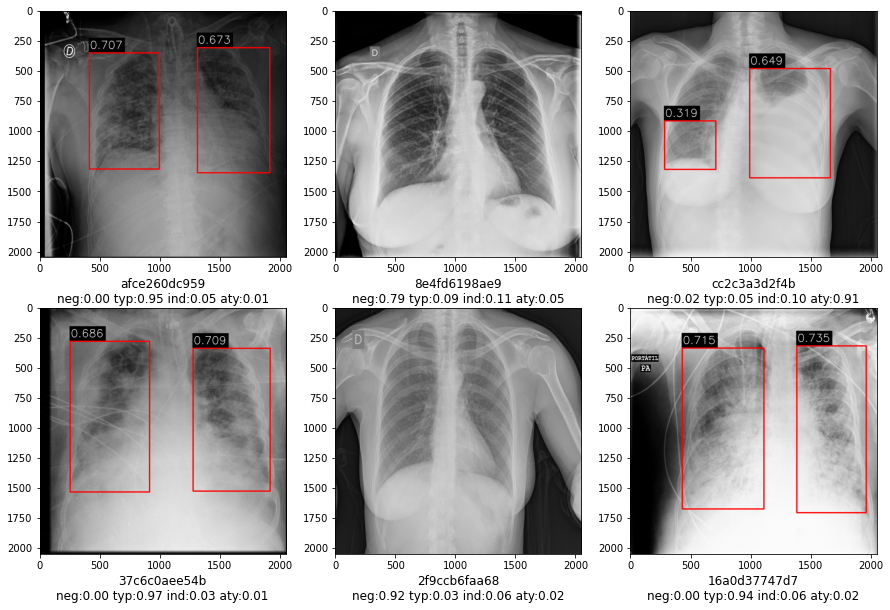

In [8]:
################################ ensembling ################################
### if negative prediction > 0.5 -> don't show box
### else -> show 2 boxes with the highest confidence
test_df = pd.read_csv('./csv/test_df.csv')
eb5_study_pred = torch.load('./predictions/timm-efficientnet-b5_512_deeplabv3plus_aux_fold0_1_2_3_4_test_pred.pth')['pred_dict']
eb6_study_pred = torch.load('./predictions/timm-efficientnet-b6_448_linknet_aux_fold0_1_2_3_4_test_pred.pth')['pred_dict']
eb7_study_pred = torch.load('./predictions/timm-efficientnet-b7_512_unetplusplus_aux_fold0_1_2_3_4_test_pred.pth')['pred_dict']
sr152_study_pred = torch.load('./predictions/timm-seresnet152d_320_512_unet_aux_fold0_1_2_3_4_test_pred.pth')['pred_dict']

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, row in test_df.iterrows():
    pred =  0.3*eb5_study_pred[row['imageid']] + \
            0.2*eb6_study_pred[row['imageid']] + \
            0.2*eb7_study_pred[row['imageid']] + \
            0.3*sr152_study_pred[row['imageid']]

    boxes1, scores1, labels1, img_width, img_height = load_dict('./predictions/tf_efficientdet_d7_768_fold0_1_2_3_4_test_pred/{}.pkl'.format(row['imageid']))

    boxes2, scores2, labels2, img_width2, img_height2 = load_dict('./predictions/yolov5x6_768_fold0_1_2_3_4_test_pred/{}.pkl'.format(row['imageid']))
    assert img_width2 == img_width and img_height2 == img_height

    boxes3, scores3, labels3, img_width3, img_height3 = load_dict('./predictions/resnet200d_768_fold0_1_2_3_4_test_pred/{}.pkl'.format(row['imageid']))
    assert img_width3 == img_width and img_height3 == img_height

    boxes4, scores4, labels4, img_width4, img_height4 = load_dict('./predictions/resnet101d_1024_fold0_1_2_3_4_test_pred/{}.pkl'.format(row['imageid']))
    assert img_width4 == img_width and img_height4 == img_height

    boxes = boxes1 + boxes2 + boxes3 + boxes4
    labels = labels1 + labels2 + labels3 + labels4

    ### scale score of fasterrcnn to effdet and yolo score
    scores3_tmp = []
    for s in scores3:
        tmp = [x*0.78 for x in s]
        scores3_tmp.append(tmp)
    scores3 = scores3_tmp

    scores4_tmp = []
    for s in scores4:
        tmp = [x*0.78 for x in s]
        scores4_tmp.append(tmp)
    scores4 = scores4_tmp

    scores = scores1 + scores2 + scores3 + scores4

    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=0.6)
    assert np.mean(labels) == 0
    boxes = boxes.clip(0,1)

    boxes[:,[0,2]] = boxes[:,[0,2]]*float(img_width)
    boxes[:,[1,3]] = boxes[:,[1,3]]*float(img_height)
    
    indexs = np.argsort(scores)[::-1]
    scores = scores[indexs][0:2]
    boxes = boxes[indexs][0:2].astype(int)
    
    image_path = './images/{}.png'.format(row['imageid'])
    image = cv2.imread(image_path)
    image = cv2.resize(image, (2048, 2048)) 
    
    if pred[0] < 0.5:
        for (x1, y1, x2, y2), score in zip(boxes, scores):
            x1 = int(x1*2048/img_width)
            x2 = int(x2*2048/img_width)
            y1 = int(y1*2048/img_height)
            y2 = int(y2*2048/img_height)

            cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 10)
            arr = np.zeros((120, 300, 3), dtype=np.uint8)
            cv2.putText(arr, '{:.3f}'.format(score), (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 4)
            image[y1-125:y1-5, x1-5:x1+295,:] = arr
                        
    ax[idx//3, idx%3].imshow(image)
    xlabel = row['imageid'] + '\n' + 'neg:{:.2f} typ:{:.2f} ind:{:.2f} aty:{:.2f}'.format(pred[0], pred[1],pred[2],pred[3])
    ax[idx//3, idx%3].set_xlabel(xlabel, fontsize=12)
plt.show()

In [9]:
!rm -rf ./images ./csv ./predictions